# Production optimisation with ensembles – an interactive tutorial

Copyright Patrick N. Raanes, NORCE, 2023.

This is a self-contained tutorial on production optimisation using ensemble methods.
- Please have a look at the [history matching (HM) tutorial](MAIN.ipynb)
  for an introduction to Python, Jupyter notebooks, and this reservoir simulator.

TODO:
- 1D: Plot ensemble of npv curves
- Plot ensemble of pdfs of npvs, including
  strategies: reactive control, nominal optimization, robust optimization
- Use model with many injectors, producers ? jansen2010closed_prez
- Cite essen, jansen, chen, fonseca, stordal, raanes

If you're on **Google Colab**, run the cell below to install the requirements.
Otherwise (and assuming you have done the installation described in the README),
you can skip/delete this cell.

In [1]:
remote = "https://raw.githubusercontent.com/patnr/HistoryMatching"
!wget -qO- {remote}/master/colab_bootstrap.sh | bash -s

Not running on Colab => Didn't do anything.


# Imports

In [2]:
import copy
from dataclasses import dataclass

In [3]:
import numpy as np
from tqdm.auto import tqdm
import numpy.random as rnd
import TPFA_ResSim as simulator
from mpl_tools.place import freshfig
from struct_tools import DotDict as Dict

In [4]:
import tools.plotting as plotting
from tools import geostat, utils, mpl_setup
from tools.utils import apply

In [5]:
mpl_setup.init()
np.set_printoptions(precision=6)

Could put this in npv() rather than copying the base model
but it's useful to have a base model in the global namespace
for plotting purposes.

In [7]:
def sample_prior_perm(N):
    lperms = geostat.gaussian_fields(model.mesh, N, r=0.8)
    return lperms

In [8]:
def perm_transf(x):
    return .1 + np.exp(5*x)

In [10]:
def set_perm(model, log_perm_array):
    """Set perm. in model code (both x and y components)."""
    p = perm_transf(log_perm_array)
    p = p.reshape(model.shape)
    model.Gridded.K = np.stack([p, p])

## Model case

In [11]:
def new_mod(**kwargs):
    """Create new model, based on `globals()['model']`."""
    # Init
    modln = copy.deepcopy(model)  # dont overwrite
    # pperm gets special treatment (transformation)
    set_perm(modln, kwargs.pop('perm', pperm))
    # Set other attrs
    for key, val in kwargs.items():
        setattr(modln, key, val)
    # Sanitize
    modln.config_wells(modln.inj_xy, modln.inj_rates,
                       modln.prod_xy, modln.prod_rates)
    return modln

In [12]:
model = simulator.ResSim(Nx=20, Ny=20, Lx=2, Ly=1)
seed = rnd.seed(3)
pperm = sample_prior_perm(1)

In [13]:
xy_4corners = np.dstack(np.meshgrid(
    np.array([.12, .87]) * model.Lx,
    np.array([.12, .87]) * model.Ly,
)).reshape((-1, 2))

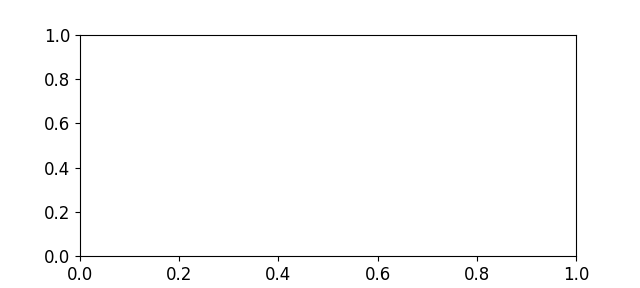

In [14]:
rate0 = 1.5
model = new_mod(
    name = "Base model",
    inj_xy  = [[model.Lx/2, model.Ly/2]],
    prod_xy = xy_4corners,
    inj_rates  = rate0 * np.ones((1, 1)) / 1,
    prod_rates = rate0 * np.ones((4, 1)) / 4,
)

fig, ax = freshfig(model.name, figsize=(1, .6), rel=True)
model.plt_field(ax, pperm, "pperm", wells=True, colorbar=True);
fig.tight_layout()

#### Simulation

Like `forward_model`, but w/o setting params

In [15]:
def sim(model, wsat, pbar=False, leave=False):
    """Simulate reservoir."""
    integrator = model.time_stepper(dt)
    wsats = simulator.recurse(integrator, nTime, wsat, pbar=pbar, leave=leave)
    # Extract production time series from water saturation fields
    wells = model.xy2ind(*model.prod_xy.T)
    prods = np.array([wsat[wells] for wsat in wsats])
    return wsats, prods

In [18]:
wsat0 = np.zeros(model.Nxy)
T = 1
dt = 0.025
nTime = round(T/dt)

In [ ]:
def plot_final_sweep(model):
    """Simulate reservoir, plot final oil saturation."""
    title = plotting.dash_join(f"Final sweep", getattr(model, "name", ""))
    wsats, prods = sim(model, wsat0)
    fig, ax = freshfig(title, figsize=(1, .6), rel=True)
    model.plt_field(ax, wsats[-1], "oil", wells=True, colorbar=True)
    fig.tight_layout()

Let us plot the final sweep given these well settings

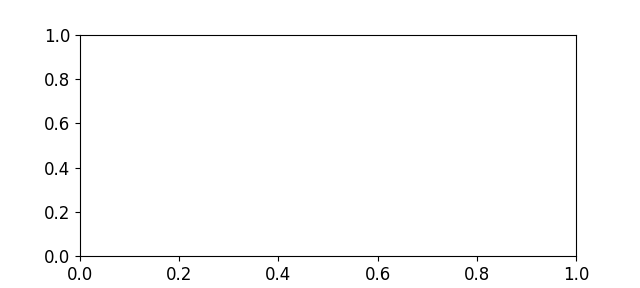

In [42]:
wsats, prods = sim(model, wsat0)
plot_final_sweep(model)

## EnOpt

In [20]:
@dataclass
class Momentum:
    """Gradient momentum (provides history memorisation)."""

    # Note: I also tried rolling average with a maxlen deque
    #       but the results of cursory testing were slightly worse.
    b: float = 0.9

    def update(self, v):
        if not hasattr(self, 'val'):
            self.reset()
        self.val *= self.b
        self.val += (1-self.b) * v

    def reset(self, val=0):
        self.val = val

In [21]:
def EnGrad(obj, u, chol, precond=False):
    U, _ = utils.center(rnd.randn(N, len(u)) @ chol.T)
    J, _ = utils.center(obj(u + U))
    if precond:
        g = U.T @ J / (N-1)
    else:
        g = utils.rinv(U, reg=.1, tikh=True) @ J
    return g

In [22]:
def EnOpt(obj, u, chol, sign=+1,
          # Step modifiers:
          regulator=None, xSteps=(1,), normed=True, precond=True,
          # Stopping criteria:
          nIter=100, rtol=1e-4):
    """Gradient/steepest *descent* using ensemble (LLS) gradient and backtracking.

    - `rtol` specified how large an improvement is required to update the iterate.
      Large values makes backtracking more reluctant to accept an update,
      resulting in *faster* declaration of convergence.
      Setting to 0 is not recommended, because if the objective function is flat
      in the neighborhood, then the path could just go in circles on that flat.
    """

    def backtrack(base_step):
        """Line search by bisection."""
        with tqdm(total=len(xSteps), desc="Backtrack", leave=False) as pbar:
            for i, xStep in enumerate(xSteps):
                pbar.update(1)
                x = path[-1] + sign * xStep * base_step
                J = obj(x)
                if sign*(J - objs[-1]) > atol:
                    pbar.update(len(xSteps))  # needed in Jupyter
                    return x, J, i

    # Init
    if regulator:
        regulator.reset()
    J = obj(u)
    atol = max(1e-8, abs(J)) * rtol
    info, path, objs = {}, [], []

    for itr in range(nIter):
        path.append(u)
        objs.append(J)

        # Compute search direction
        grad = EnGrad(obj, u, chol, precond=precond)
        if normed:
            grad /= utils.mnorm(grad)
        if regulator:
            regulator.update(grad)

        # Update iterate
        if not regulator or not (updated := backtrack(regulator.val)):
            if regulator:
                regulator.reset(grad)
                info.setdefault('resets', []).append(itr)
            # Fallback to pure grad
            if not (updated := backtrack(grad)):
                # Stop if lower J not found
                status = "Converged ✅"
                break
        u, J, i = updated
        info.setdefault('nDeclined', []).append(i)

    else:
        status = "Ran out of iters ❌"

    print(f"{status:<9} {itr=:<5}  {path[-1]=}  {objs[-1]=:.2f}")
    return np.array(path), np.array(objs), info

In [23]:
N = 10
xSteps = [.4 * 1/2**i for i in range(8)]
utils.nCPU = True

## NPV objective functions

In [24]:
## Objectives
def prod2npv(model, prods):
    """Net present value (NPV), i.e. monetarily discounted, total oil production."""
    discounts = .99 ** np.arange(nTime + 1)
    prods = 1 - prods                   # water --> oil
    prods = prods * model.prod_rates.T  # volume = saturation * rate
    prods = np.sum(prods, -1)           # sum over wells
    value = prods @ discounts           # sum in time, incld. discount factors
    # Compute cost of water injection
    # PS: We don't bother with cost of water production,
    # since it is implicitly approximated by reduction in oil production.
    inj_rates = model.inj_rates
    if inj_rates.shape[1] == 1:
        inj_rates = np.tile(inj_rates, (1, nTime))
    cost = np.sum(inj_rates, 0)
    cost = cost @ discounts[:-1]
    return value - .5*cost

In [25]:
def npv(**kwargs):
    """NPV from model config."""
    # Config
    try:
        model = new_mod(**kwargs)
        # Simulate
        wsats, prods = sim(model, wsat0)
    except Exception:
        return 0  # Invalid model params. Penalize. Use `raise` for debugging.
    return prod2npv(model, prods)

In [26]:
def npv_in_injectors(xys):
    """`npv(inj_xy)`. Input shape `(nEns, 2*nInj)`."""
    xys, singleton = utils.atleast_2d(xys)
    xys = xys.reshape((len(xys), -1, 2))  # (nEns, 2*nInj) --> (nEns, nInj, 2)
    Js = apply(npv, inj_xy=xys, unzip=False,
               pbar=not singleton, leave=False)
    return Js[0] if singleton else Js

In [27]:
def npv_in_x_of_inj0_with_fixed_y(x):
    """Like `npv_in_injectors` but with `y` fixed. Input shape `(nEns, 1)` or `(1,)`."""
    xs = x
    ys = y * np.ones_like(xs)
    xys = np.hstack([xs, ys])
    Js = npv_in_injectors(xys)
    return Js

obj = npv_in_x_of_inj0_with_fixed_y
y = model.Ly/2

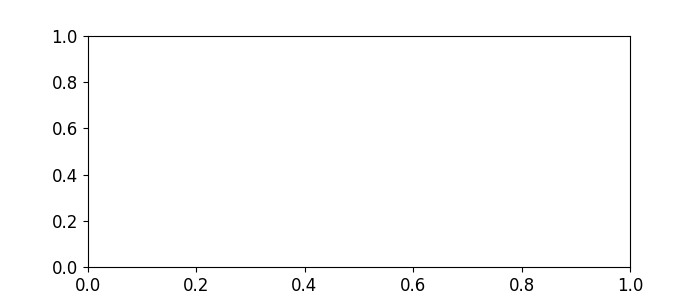

npv's:   0%|          | 0/201 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=2      path[-1]=array([0.9])  objs[-1]=17.38


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.8])  objs[-1]=17.94


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=1      path[-1]=array([0.8])  objs[-1]=17.94


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=2      path[-1]=array([0.8])  objs[-1]=17.94


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.8])  objs[-1]=18.34


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=3      path[-1]=array([0.7])  objs[-1]=18.34


In [28]:
# Plot entire objective
fig, ax = freshfig(f"{obj.__name__}({y})", figsize=(7, 3))
ax.set(xlabel="x", ylabel="NPV")
xx = np.linspace(0, model.Lx, 201)
npvs = obj(np.atleast_2d(xx).T)
ax.plot(xx, npvs, "slategrey", lw=3)

# Optimize
L = .3 * np.eye(1)
shifts = {}
u0s = model.Lx * np.array([[.05, .1, .2, .8, .9, .95]]).T
for i, u0 in enumerate(u0s):
    path, objs, info = EnOpt(obj, u0, L, regulator=None, xSteps=xSteps)
    shift = .3*i  # for visual distinction
    ax.plot(path, objs - shift, '-o', c=f'C{i+1}')
fig.tight_layout()

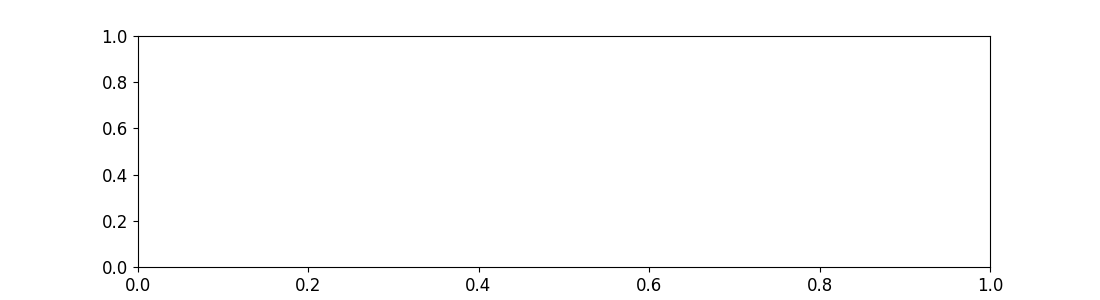

npv's:   0%|          | 0/400 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=2      path[-1]=array([0.723249, 0.415928])  objs[-1]=18.21


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=5      path[-1]=array([0.75347 , 0.528647])  objs[-1]=18.34


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=4      path[-1]=array([0.750314, 0.53891 ])  objs[-1]=18.34


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=4      path[-1]=array([0.7888  , 0.473383])  objs[-1]=18.42


In [29]:
obj = npv_in_injectors
fig, axs = plotting.figure12(obj.__name__)

# Plot entire objective

X, Y = model.mesh
XY = np.vstack([X.ravel(), Y.ravel()]).T
npvs = obj(XY)
model.plt_field(axs[0], npvs, "NPV", wells=True, argmax=True, colorbar=True);
fig.tight_layout()

# Optimize

L = .1 * np.eye(2)
for color in ['C0', 'C2', 'C7', 'C9']:
    u0 = rnd.rand(2) * model.domain[1]
    path, objs, info = EnOpt(obj, u0, L, regulator=Momentum(0.3), xSteps=xSteps, precond=False)
    plotting.add_path12(*axs, path, objs, color=color)

#### Comments
- Some get stuck in local minima
- Smaller steps towards end
- Notice that discreteness of npv_in_injectors function means that
  they dont all CV to exactly the same

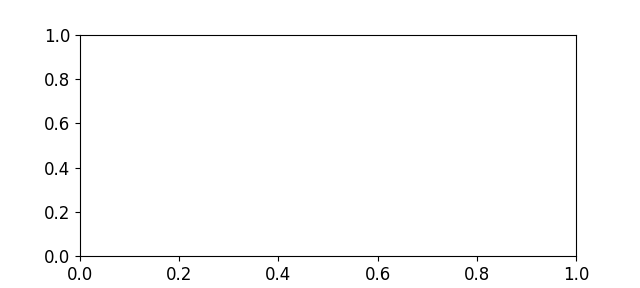

In [30]:
model = new_mod(inj_xy=path[-1].reshape((-1, 2)),
                name=f"Optimized in {obj.__name__}")
plot_final_sweep(model)

In [31]:
def transform_xys(xys):
    """Transform infinite plane to `(0, Lx) x (0, Ly)`."""
    def realline_to_0L(x, L, compress=1):
        sigmoid = lambda z: 1/(1 + np.exp(-z))  # noqa
        x = (x - L/2) * L * compress
        return L * sigmoid(x)

    xys = np.array(xys, dtype=float)

    # Loop over (x, y)
    for i0, L in zip([0, 1], model.domain[1]):
        ii = slice(i0, None, 2)
        xys[..., ii] = realline_to_0L(xys[..., ii], L, 1)
    return xys

In [32]:
def npv_in_injectors_transformed(xys):
    return npv_in_injectors(transform_xys(xys))

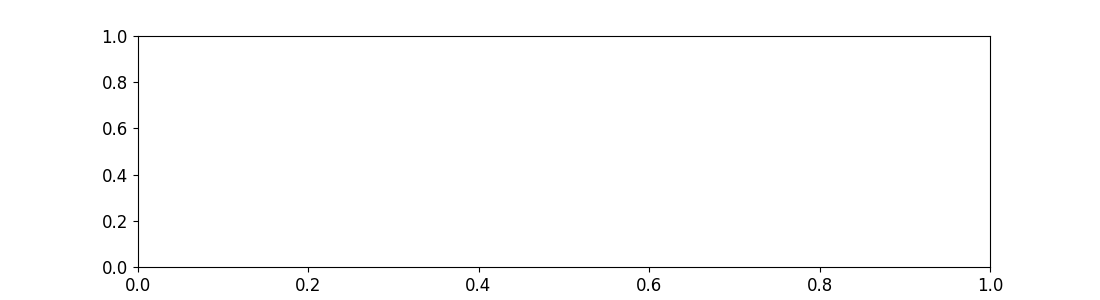

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=8      path[-1]=array([0.760458, 2.036399, 3.282515, 2.078538])  objs[-1]=20.59


In [33]:
obj = npv_in_injectors_transformed

u0 = np.array([0, 0] + [2, 0])
model = new_mod(
    name = "Lower 2 corners",
    prod_xy = xy_4corners[:2],
    inj_xy  = transform_xys(u0).reshape((2, 2)),
    prod_rates = rate0 * np.ones((2, 1)) / 2,
    inj_rates  = rate0 * np.ones((2, 1)) / 2,
)
fig, axs = plotting.figure12(obj.__name__)
model.plt_field(axs[0], pperm, "pperm", wells=True, colorbar=True)

L = .1 * np.eye(len(u0))
path, objs, info = EnOpt(obj, u0, L, regulator=Momentum(.1), xSteps=xSteps, precond=False, rtol=1e-8)
path = transform_xys(path)

plotting.add_path12(*axs, path[:, :2], objs, color='C0')
plotting.add_path12(*axs, path[:, 2:], color='C5')
fig.tight_layout()

Let's optimize

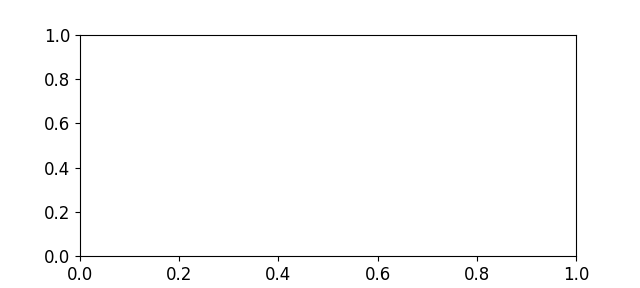

In [34]:
model = new_mod(inj_xy=path[-1].reshape((-1, 2)),
                name=f"Optimzed in {obj.__name__}")
plot_final_sweep(model)

## Rates

In [35]:
def npv_in_rates(inj_rates):
    """`npv(inj_rates)`. Input shape `(nEns, nInj)`."""
    inj_rates, singleton = utils.atleast_2d(inj_rates)
    nEns = len(inj_rates)
    inj_rates = inj_rates.reshape((nEns, -1, 1))  # (nEns, nInj) --> (nEns, nInj, 1)
    total_rate = np.sum(inj_rates, axis=1).squeeze()  # (nEns,)
    nProd = len(model.prod_rates)
    prod_rates = (np.ones((1, nProd, nEns)) * total_rate/nProd).T
    Js = apply(npv, inj_rates=inj_rates, prod_rates=prod_rates, unzip=False,
               pbar=not singleton, leave=False)
    return Js[0] if singleton else Js

In [36]:
# Restore default well config
model = new_mod(
    name = "Base model",
    inj_xy  = [[model.Lx/2, model.Ly/2]],
    prod_xy = xy_4corners,
    inj_rates  = rate0 * np.ones((1, 1)) / 1,
    prod_rates = rate0 * np.ones((4, 1)) / 4,
)

npv's:   0%|          | 0/21 [00:00<?, ?it/s]

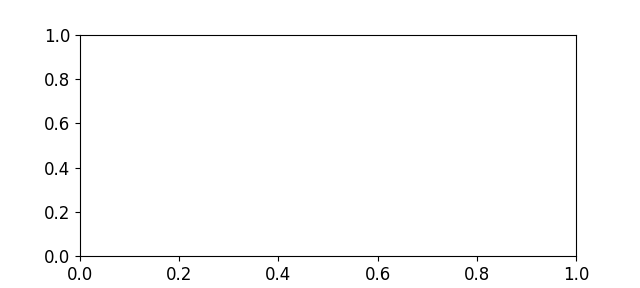

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=7      path[-1]=array([1.75625])  objs[-1]=17.29


npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

npv's:   0%|          | 0/10 [00:00<?, ?it/s]

Backtrack:   0%|          | 0/8 [00:00<?, ?it/s]

Converged ✅ itr=10     path[-1]=array([1.75625])  objs[-1]=17.29


In [37]:
obj = npv_in_rates

xx = np.linspace(0.1, 5, 21)
npvs = obj(np.atleast_2d(xx).T)

fig, ax = freshfig(obj.__name__, figsize=(1, .4), rel=True)
ax.grid()
ax.set(xlabel="rate", ylabel="NPV")
ax.plot(xx, npvs, "slategrey")

for i, u0 in enumerate(np.array([[.1, 5]]).T):
    L = .1 * np.eye(len(u0))
    path, objs, info = EnOpt(obj, u0, L, xSteps=xSteps, precond=False, rtol=1e-8)
    shift = i+1  # for visual distinction
    ax.plot(path, objs - shift, '-o', color=f'C{i+1}')
fig.tight_layout()

# Triangles

In [38]:
triangle = [0, 135, -135]
wells = dict(
    inj_xy = ([[model.Lx/2, model.Ly/2]] +
              [utils.xy_p_normed(th + 90, *model.domain[1]) for th in triangle]),
    prod_xy = [utils.xy_p_normed(th - 90, *model.domain[1]) for th in triangle],
    inj_rates = rate0 * np.ones((4, 1)) / 4,
    prod_rates = rate0 * np.ones((3, 1)) / 3,
)
model = new_mod(**wells)

In [39]:
fig, ax = freshfig("Triangle case", figsize=(1, .6), rel=True)
model.plt_field(ax, pperm, "pperm", wells=True, colorbar=True);
fig.tight_layout()

In [40]:
def final_sweep_given_inj_rates(**kwargs):
    inj_rates = np.array([list(kwargs.values())]).T
    prod_rates = np.ones((3, 1)) / 3 * np.sum(inj_rates)
    model = new_mod(inj_rates=inj_rates, prod_rates=prod_rates)
    wsats, prods = sim(model, wsat0)
    npv = prod2npv(model, prods)
    print(f"NPV for these injection_rates: {npv:.5f}")
    return wsats[-1]

In [ ]:
final_sweep_given_inj_rates.controls = dict(
    i0 = (0, 1.4),
    i1 = (0, 1.4),
    i2 = (0, 1.4),
    i3 = (0, 1.4),
)

In [ ]:
plotting.field_console(model, final_sweep_given_inj_rates, "oil", wells=True, figsize=(1, .6))

## Optim triangles

In [ ]:
u0 = .7*np.ones(len(model.inj_rates))
L = .1 * np.eye(len(u0))
path, objs, info = EnOpt(npv_in_rates, u0, L, xSteps=xSteps, precond=False, rtol=1e-8)

Now try setting these values in the interactive widget above.